In [ ]:
#Importo las librerias necesarias
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Input,SimpleRNN,Reshape,LSTM,TimeDistributed
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler


rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

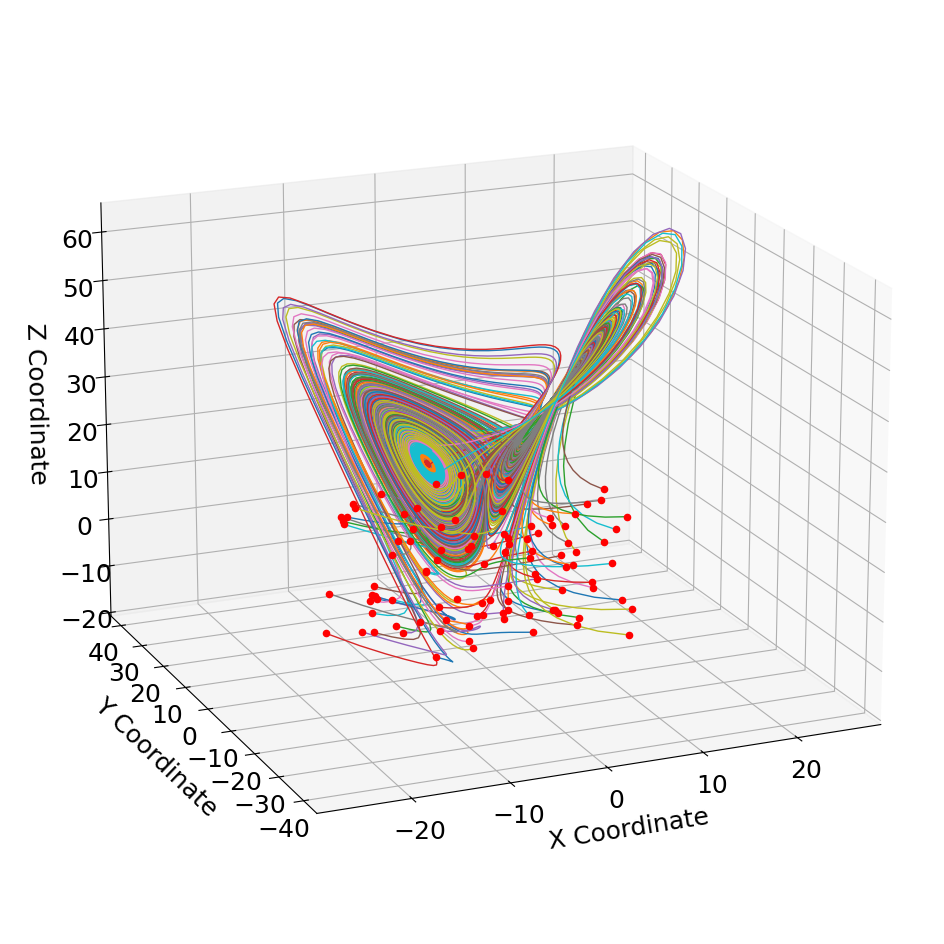

In [ ]:
#Simulate Lorentz System

dt=0.01
T=8
t=np.arange(0,T+dt,dt)
beta=8/3
sigma=10
rho=28


nn_input=np.zeros((100*(len(t)-1),3))
nn_output=np.zeros_like(nn_input)

fig,ax=plt.subplots(1,1,subplot_kw={'projection':'3d'})


def lorenz_deriv(x_y_z,t0,sigma=sigma,beta=beta,rho=rho):
    x, y, z=x_y_z
    return [sigma*(y-x),x*(rho-z)-y,x*y-beta*z]

np.random.seed(123)
x0=-15+30*np.random.random((100,3))

x_t=np.asarray([integrate.odeint(lorenz_deriv,x0_j,t)
                  for x0_j in x0])

for j in range(100):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:]=x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:]=x_t[j,1:,:]
    x,y,z=x_t[j,:,:].T
    ax.plot(x,y,z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')

ax.view_init(18,-113)
ax.set_xlabel('X Coordinate',labelpad=12)
ax.set_ylabel('Y Coordinate',labelpad=12)
ax.set_zlabel('Z Coordinate',labelpad=12)
plt.show()

In [ ]:
#Extraigo en primer lugar los datos (Datos para los modelos con RNN y LSTM)
x_train_1, y_train_1= x_t[:70,:-1], x_t[:70,1:]
x_eval_1, y_eval_1=x_t[70:80,:-1], x_t[70:80,1:]
x_test_1, y_test_1=x_t[80:,:-1], x_t[80:,1:]

#Guardo las trayectorias teóricas del test para poder compararlas con las de los modelos posteriormente
y_comprobacion=y_test_1

#Me guardo las dimensiones originales para hacer un reshape posterior
y_test_dim=y_test_1.shape

#Normalizo ahora los datos
scaler=StandardScaler()
x_train_1=scaler.fit_transform(x_train_1.reshape(-1,3)).reshape(x_train_1.shape)
x_eval_1=scaler.transform(x_eval_1.reshape(-1,3)).reshape(x_eval_1.shape)
x_test_1=scaler.transform(x_test_1.reshape(-1,3)).reshape(x_test_1.shape)

scaler_y=StandardScaler()
y_train_1=scaler_y.fit_transform(y_train_1.reshape(-1,3)).reshape(y_train_1.shape)
y_eval_1=scaler_y.transform(y_eval_1.reshape(-1,3)).reshape(y_eval_1.shape)
y_test_1=scaler_y.transform(y_test_1.reshape(-1,3)).reshape(y_test_1.shape)

In [ ]:
#Primero planteo el modelo de la red neuronal feedforward sencilla

#Me genero el modelo
red_neuronal=Sequential(layers=[
    Input(shape=(None,3)),
    Dense(64,activation='relu'),
    Dense(64,activation='relu'),
    Dense(3)
])

#Una vez generado el modelo lo compilamos asignando el optimizador y la función de pérdida adecuadas

red_neuronal.compile(optimizer='adam',loss='mse')

#Una vez generado mi modelo completo lo entreno

history=red_neuronal.fit(x_train_1,y_train_1,epochs=100,validation_data=(x_eval_1,y_eval_1))

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.9925 - val_loss: 0.8703
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.8456 - val_loss: 0.7515
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.7403 - val_loss: 0.6431
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.6235 - val_loss: 0.5435
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.5315 - val_loss: 0.4506
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.4364 - val_loss: 0.3657
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.3509 - val_loss: 0.2887
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.2747 - val_loss: 0.2196
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.2089 - val_loss: 0.1600
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.1514 - val_loss: 0.1114
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.1040 - val_loss: 0.0750
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0708 - v

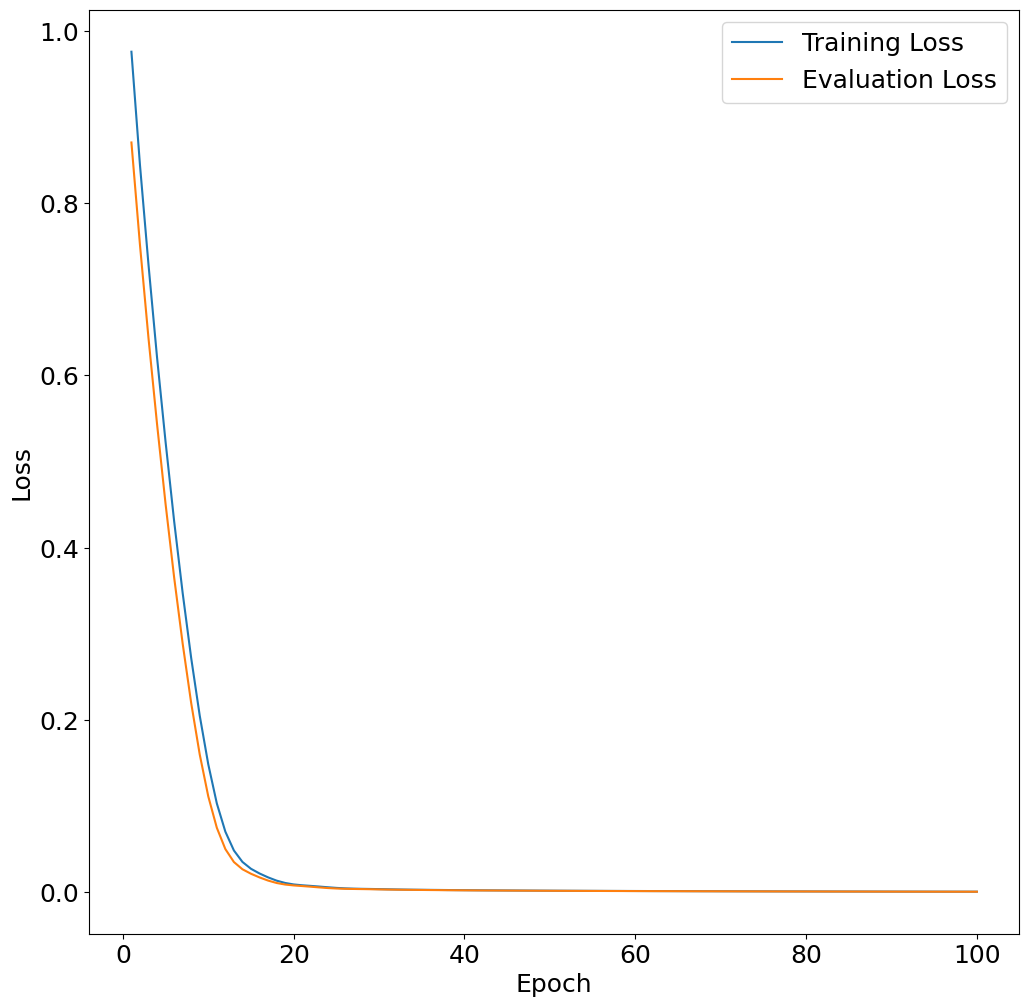

In [ ]:
#En esta parte del código dibujo la pérdida de la validación y del entreno
#Extraigo los datos necesarios
train_loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(train_loss)+1)

#Ahora hago un plot con estos datos
plt.plot(epochs,train_loss,label='Training Loss')     #Plot para la pérdida del entrenamiento
plt.plot(epochs,val_loss,label='Evaluation Loss')     #Plot para la pérdida de la evaluacion
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


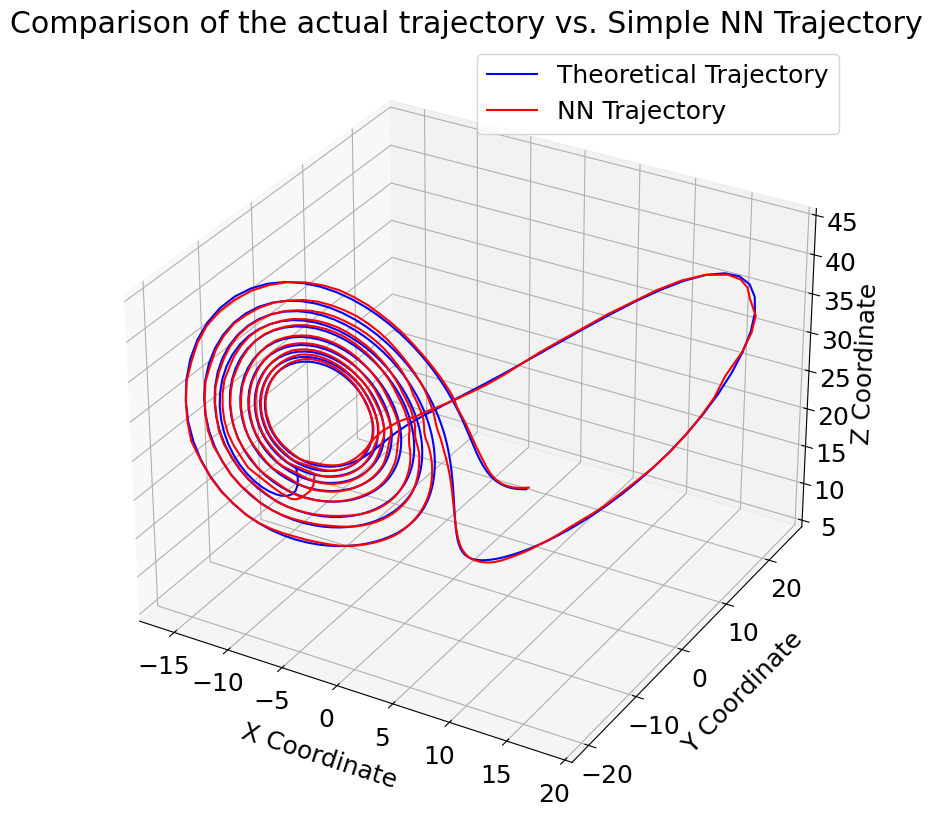

In [ ]:
#Ahora dibujo algunas trayectorias para estudiar el funcionamiento del modelo

#Le aplico el modelo a los datos de testeo
result_pred=red_neuronal.predict(x_test_1)

#Deshago la transformacion de las trayectorias
result_pred=scaler_y.inverse_transform(result_pred.reshape(-1,3)).reshape(result_pred.shape)

#Extraigo los datos correspondientes a la trayectoria real
x_real=y_comprobacion[0,:,0]
y_real=y_comprobacion[0,:,1]
z_real=y_comprobacion[0,:,2]

#Reajusto los datos a una dimensión en la que me sea más sencillo extraerlos para dibujar trayectorias
result_pred=result_pred.reshape(y_test_dim)

#Extraigo los datos predecidos por la red neuronal
x_pred=result_pred[0,:,0]
y_pred=result_pred[0,:,1]
z_pred=result_pred[0,:,2]

#Hago una figura
fig=plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax=fig.add_subplot(111, projection='3d')

ax.plot(x_real,y_real,z_real, label='Theoretical Trajectory', color='blue')

ax.plot(x_pred,y_pred,z_pred, label='NN Trajectory', color='red')

ax.set_xlabel('X Coordinate',labelpad=13)
ax.set_ylabel('Y Coordinate',labelpad=13)
ax.set_zlabel('Z Coordinate')
ax.set_title('Comparison of the actual trajectory vs. Simple NN Trajectory')
ax.legend()
plt.show()

In [ ]:
#Ahora hago una red RNN

#Genero el modelo que vamos a usar
red_RNN=Sequential(layers=[
     Input(shape=(None,3)),
     SimpleRNN(64,activation='relu',return_sequences=True),
     Dense(64,activation='relu'),
     Dense(3)
])

#Compilo el modelo como en el caso anterior
red_RNN.compile(optimizer='Adam',loss='mse')

#Una vez generado mi modelo completo lo entreno
entrenamiento_2=red_RNN.fit(x_train_1,y_train_1,epochs=100,validation_data=(x_eval_1,y_eval_1))

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step - loss: 1.1860 - val_loss: 0.8421
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - loss: 0.8269 - val_loss: 0.5438
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - loss: 0.5291 - val_loss: 0.2864
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - loss: 0.2873 - val_loss: 0.1936
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.2048 - val_loss: 0.1300
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 0.1336 - val_loss: 0.0771
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0835 - val_loss: 0.0606
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 0.0667 - val_loss: 0.0515
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 0.0537 - val_loss: 0.0416
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.0430 - val_loss: 0.0329
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 464ms/step - loss: 0.0334 - val_loss: 0.0253
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step - loss: 0.0

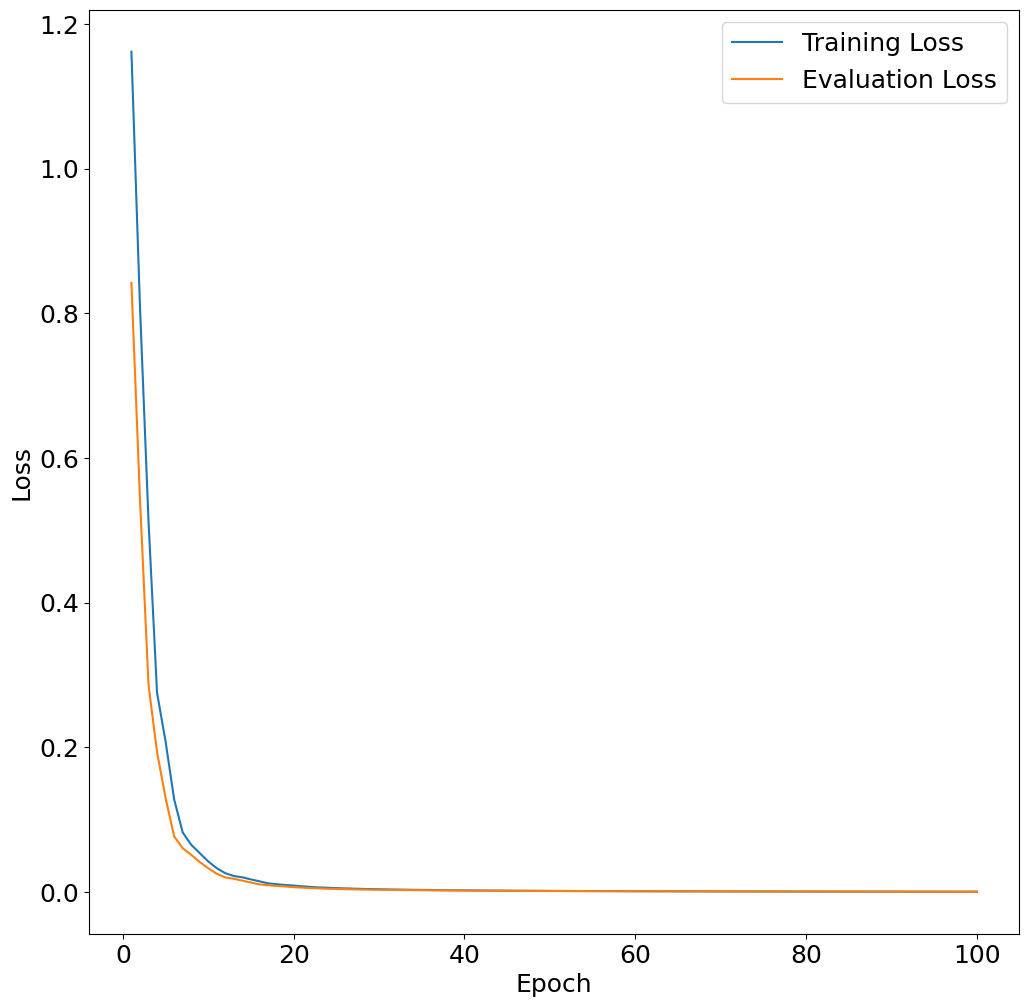

In [ ]:
#En esta parte del código dibujo la pérdida de la validación y del entreno
#Extraigo los datos necesarios
train_loss_2=entrenamiento_2.history['loss']
val_loss_2=entrenamiento_2.history['val_loss']
epochs_2=range(1,len(train_loss_2)+1)

#Ahora hago un plot con estos datos
plt.plot(epochs_2,train_loss_2,label='Training Loss')     #Plot para la pérdida del entrenamiento
plt.plot(epochs_2,val_loss_2,label='Evaluation Loss')     #Plot para la pérdida de la evaluacion
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


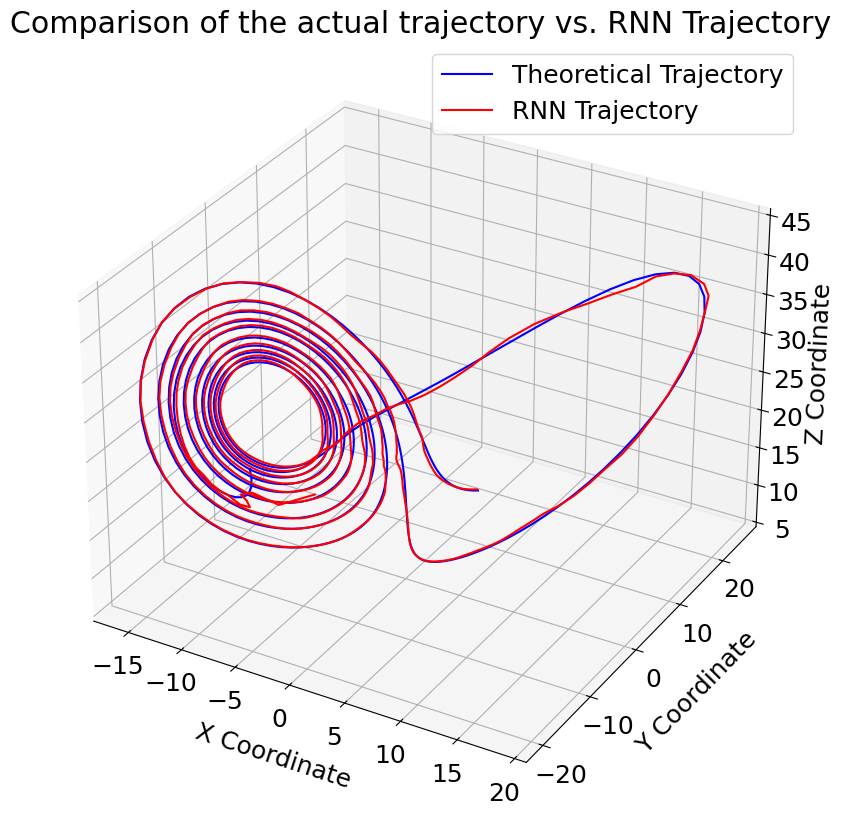

In [ ]:
#Ahora dibujo algunas trayectorias para estudiar el funcionamiento del modelo

#Le aplico el modelo a los datos de testeo
result_pred_2=red_RNN.predict(x_test_1)

#Deshago la transformacion
result_pred_2=scaler_y.inverse_transform(result_pred_2.reshape(-1,3)).reshape(result_pred_2.shape)

#Extraigo los datos correspondientes a la trayectoria real
x_real=y_comprobacion[0,:,0]
y_real=y_comprobacion[0,:,1]
z_real=y_comprobacion[0,:,2]

#Aplicamos un reshape a los resultados predichos para facilitar extraer las trayectorias
result_pred_2=result_pred_2.reshape(y_test_dim)

#Extraigo una trayectoria
x_pred_2=result_pred_2[0,:,0]
y_pred_2=result_pred_2[0,:,1]
z_pred_2=result_pred_2[0,:,2]

#Hago una figura
fig=plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax=fig.add_subplot(111, projection='3d')

ax.plot(x_real,y_real,z_real, label='Theoretical Trajectory', color='blue')

ax.plot(x_pred_2,y_pred_2,z_pred_2, label='RNN Trajectory', color='red')

ax.set_xlabel('X Coordinate',labelpad=13)
ax.set_ylabel('Y Coordinate',labelpad=13)
ax.set_zlabel('Z Coordinate')
ax.set_title('Comparison of the actual trajectory vs. RNN Trajectory')
ax.legend()
plt.show()

In [ ]:
#Por último planteo una LSTM

#Genero el modelo que vamos a usar
red_LSTM=Sequential(layers=[
    Input(shape=(None,3)),
    LSTM(64,activation='tanh',return_sequences=True),
    Dense(64,activation='tanh'),
    Dense(3)
])

#Compilo el modelo como en el caso anterior
red_LSTM.compile(optimizer=Adam(learning_rate=0.01),loss='mse')

#Una vez generado mi modelo completo lo entreno
entrenamiento_3=red_LSTM.fit(x_train_1,y_train_1,epochs=100,validation_data=(x_eval_1,y_eval_1))

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 529ms/step - loss: 0.8021 - val_loss: 0.1929
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step - loss: 0.1583 - val_loss: 0.0779
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - loss: 0.0687 - val_loss: 0.0523
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step - loss: 0.0454 - val_loss: 0.0305
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 616ms/step - loss: 0.0338 - val_loss: 0.0221
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - loss: 0.0205 - val_loss: 0.0161
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step - loss: 0.0188 - val_loss: 0.0101
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step - loss: 0.0111 - val_loss: 0.0075
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step - loss: 0.0078 - val_loss: 0.0079
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step - loss: 0.0087 - val_loss: 0.0046
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - loss: 0.0

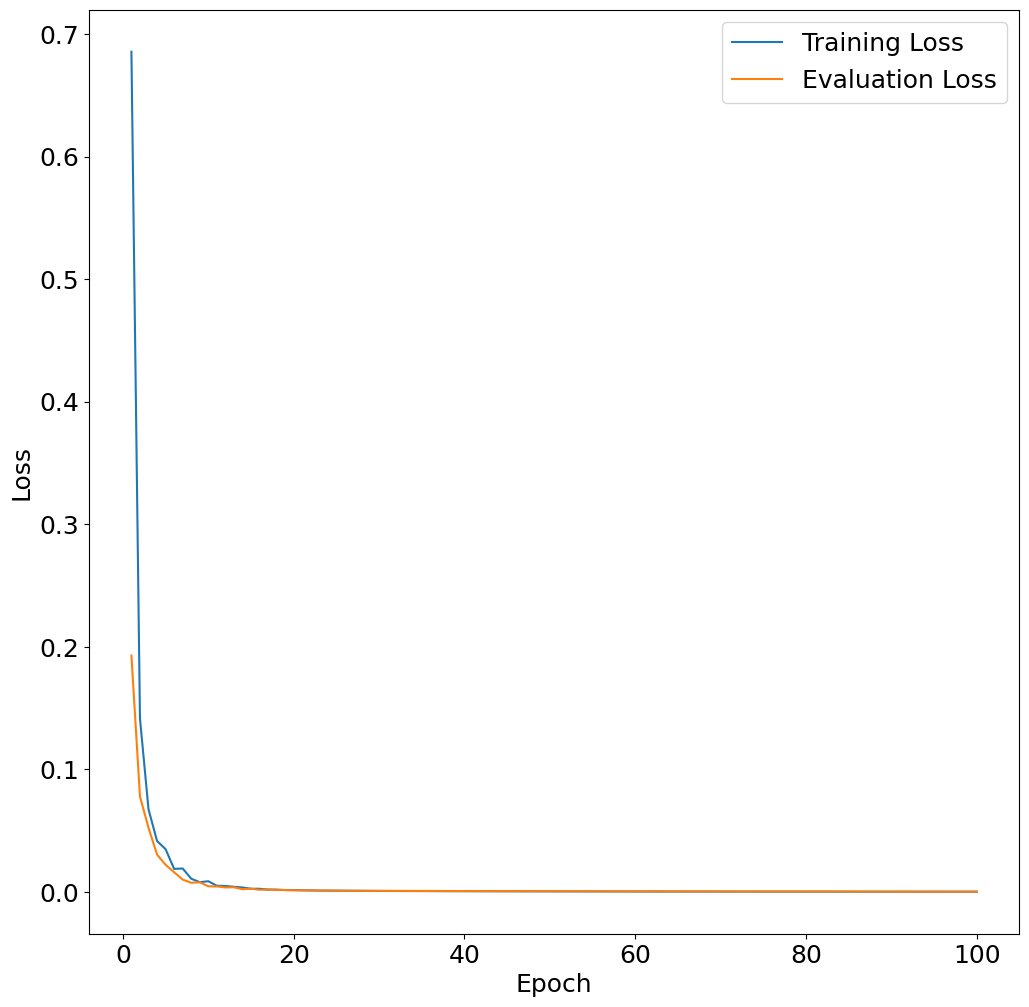

In [ ]:
#Dibujo las funciones de pérdida correspondientes al entrenamiento y la evaluación
#Extraigo los datos necesarios
train_loss_3=entrenamiento_3.history['loss']
val_loss_3=entrenamiento_3.history['val_loss']
epochs_3=range(1,len(train_loss_3)+1)

#Ahora hago un plot con estos datos
plt.plot(epochs_3,train_loss_3,label='Training Loss')     #Plot para la pérdida del entrenamiento
plt.plot(epochs_3,val_loss_3,label='Evaluation Loss')     #Plot para la pérdida de la evaluacion
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step


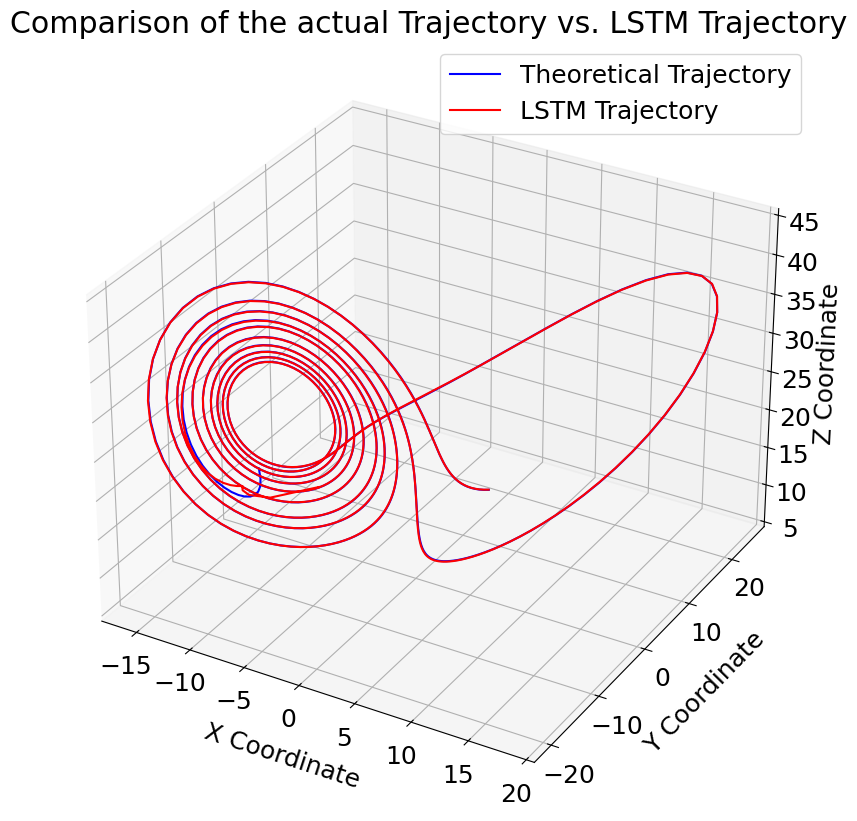

In [ ]:
#Dibujo alguna trayectoria para ver visualmente el funcionamiento del modelo

#Le aplico el modelo a los datos de testeo
result_pred_3=red_LSTM.predict(x_test_1)

#Deshago la normalizacion
result_pred_3=scaler_y.inverse_transform(result_pred_3.reshape(-1,3)).reshape(result_pred_3.shape)

#Extraigo los datos correspondientes a la trayectoria real
x_real=y_comprobacion[0,:,0]
y_real=y_comprobacion[0,:,1]
z_real=y_comprobacion[0,:,2]

#Aplicamos un reshape a los resultados predichos para facilitar extraer las trayectorias
result_pred_3=result_pred_3.reshape(y_test_dim)

#Extraigo una trayectoria
x_pred_3=result_pred_3[0,:,0]
y_pred_3=result_pred_3[0,:,1]
z_pred_3=result_pred_3[0,:,2]

#Hago una figura

fig=plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax=fig.add_subplot(111, projection='3d')

ax.plot(x_real,y_real,z_real, label='Theoretical Trajectory', color='blue')

ax.plot(x_pred_3,y_pred_3,z_pred_3, label='LSTM Trajectory', color='red')

ax.set_xlabel('X Coordinate',labelpad=13)
ax.set_ylabel('Y Coordinate',labelpad=13)
ax.set_zlabel('Z Coordinate')
ax.set_title('Comparison of the actual Trajectory vs. LSTM Trajectory')
ax.legend()
plt.show()
